In [65]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.insert(0, '../HD-BET/HD_BET')

In [32]:
out = os.system("cd")
# hd_bet()
# out = os.system("py hd-bet -i 'C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2/001/T1w_1mm.nii.gz'")
print(out)

0


In [141]:
T1w = sitk.ReadImage("C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2/002/T1w_1mm_bet.nii.gz")
T2w = sitk.ReadImage("C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2/002/T2w_1mm_noalign_bet.nii.gz")
FA = sitk.ReadImage("C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2/002/FA_deformed_bet.nii.gz")
ADC = sitk.ReadImage("C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2/002/ADC_deformed_bet.nii.gz")
FAscaled = sitk.Resample(FA, T1w, sitk.ScaleTransform(3, (1, 1, 1)))
ADCscaled = sitk.Resample(ADC, T1w, sitk.ScaleTransform(3, (1, 1, 1)))

In [142]:
# FA AND ADC REGISTRATION
initial_transformFA = sitk.CenteredTransformInitializer(T1w, 
                                                      FAscaled, 
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_methodFA = sitk.ImageRegistrationMethod()
registration_methodFA.SetMetricAsJointHistogramMutualInformation(numberOfHistogramBins=50)
registration_methodFA.SetMetricSamplingStrategy(registration_methodFA.RANDOM)
registration_methodFA.SetMetricSamplingPercentage(0.01, 1)

registration_methodFA.SetInterpolator(sitk.sitkLinear)
registration_methodFA.SetOptimizerAsGradientDescent(learningRate=1.5, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_methodFA.SetInitialTransform(initial_transformFA, inPlace=False)

final_transformFA = registration_methodFA.Execute(T1w, FAscaled)
# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_methodFA.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_methodFA.GetOptimizerStopConditionDescription()))

Final metric value: -1.1613370381034578
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 62.


In [143]:
# T2W REGISTRATION

initial_transformT2w = sitk.CenteredTransformInitializer(T1w, 
                                                      T2w, 
                                                      sitk.VersorRigid3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_methodT2w = sitk.ImageRegistrationMethod()
registration_methodT2w.SetMetricAsJointHistogramMutualInformation(numberOfHistogramBins=50)
registration_methodT2w.SetMetricSamplingStrategy(registration_methodT2w.RANDOM)
registration_methodT2w.SetMetricSamplingPercentage(0.01, 1)

registration_methodT2w.SetInterpolator(sitk.sitkLinear)
registration_methodT2w.SetOptimizerAsGradientDescent(learningRate=1.5, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_methodT2w.SetInitialTransform(initial_transformT2w, inPlace=False)

final_transformT2w = registration_methodT2w.Execute(T1w, T2w)
# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_methodT2w.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_methodT2w.GetOptimizerStopConditionDescription()))

Final metric value: -0.5776169531456553
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


(145, 174, 145) (182, 218, 182) (182, 218, 182) (182, 218, 182) (182, 218, 182)


Text(0.5, 1.0, 'T1w')

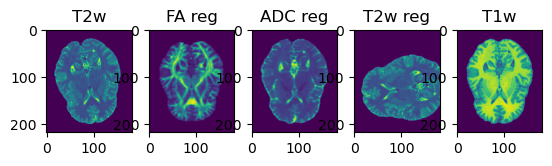

In [144]:
ADCreg = sitk.Resample(ADCscaled, T1w, final_transformFA)
FAreg = sitk.Resample(FAscaled, T1w, final_transformFA)

T2wreg = sitk.Resample(T2w, T1w, sitk.VersorTransform((0, 0, 1), np.pi/2))
# sitk.WriteImage(T2wreg, 'T2_1mm_noalign_registered.nii.gz')
FAscaledownreg = sitk.Resample(FAreg, FA, sitk.ScaleTransform(3, (1, 1, 1)))
FAscaledownreg_arr = sitk.GetArrayFromImage(FAscaledownreg)
FAreg_arr = sitk.GetArrayFromImage(FAreg)
ADCreg_arr = sitk.GetArrayFromImage(ADCreg)
T2wreg_arr = sitk.GetArrayFromImage(T2wreg)
T2w_arr = sitk.GetArrayFromImage(T2w)
FA_arr = sitk.GetArrayFromImage(FA)
T1w_arr = sitk.GetArrayFromImage(T1w)
print(FAscaledownreg_arr.shape, FAreg_arr.shape, ADCreg_arr.shape, T2wreg_arr.shape, T1w_arr.shape)
fig, axs = plt.subplots(1, 5)
slice = 75
axs[0].imshow(T2w_arr[slice, :, :])
axs[0].set_title("T2w")
axs[1].imshow(FAreg_arr[slice, :, :])
axs[1].set_title("FA reg")
axs[2].imshow(ADCreg_arr[slice, :, :])
axs[2].set_title("ADC reg")
axs[3].imshow(T2wreg_arr[slice, :, :])
axs[3].set_title("T2w reg")
axs[4].imshow(T1w_arr[slice, :, :])
axs[4].set_title("T1w")